# SIFT Feature Descriptors


# What is a Features Descriptor?

A feature descriptor is a type of representation designed for specific applications in computer vision, enabling efficient object search in images by capturing distinctive local characteristics such as edges, gradients, or textures.

# SIFT Feature Descriptors and Panorama Generation with OpenCV

## 1. SIFT Feature Descriptors

The **Scale-Invariant Feature Transform (SIFT)** is a method to extract distinctive keypoints and their corresponding descriptors from an image. These descriptors are robust to scale, rotation, and affine distortions.

---

### Mathematical Concepts Behind SIFT

#### **1. Scale Space Extremum Detection**
SIFT searches for potential keypoints in a scale space by convolving the input image with Gaussian kernels at different scales. The **Difference-of-Gaussians (DoG)** is computed as:

$$
D(x, y, \sigma) = [G(x, y, k\sigma) - G(x, y, \sigma)] * I(x, y)
$$

Where:

- $ G(x, y, \sigma) $ is the Gaussian filter with standard deviation $ \sigma $
- $ I(x, y) $ is the image
- $ k $ is a multiplicative factor for scaling

---

#### **2. Keypoint Localization**
The keypoint candidates detected from DoG are refined using a Taylor series expansion to fit a 3D quadratic function. This helps reject low-contrast points and edge-like responses.

---

#### **3. Orientation Assignment**
Each keypoint is assigned one or more orientations based on local image gradient directions.

The **gradient magnitude** and **orientation** are computed as:

$$
m(x, y) = \sqrt{(I(x+1, y) - I(x-1, y))^2 + (I(x, y+1) - I(x, y-1))^2}
$$

$$
\theta(x, y) = \tan^{-1} \left(\frac{I(x, y+1) - I(x, y-1)}{I(x+1, y) - I(x-1, y)}\right)
$$

A histogram of orientations is built, and the dominant peak is assigned as the keypoint orientation.


#### **4. Keypoint Descriptor**
To create the SIFT descriptor:

- A 16x16 region around each keypoint is divided into 4x4 cells.
- In each cell, a histogram of gradient orientations (typically 8 bins) is computed.
- This results in a feature vector of length 128 (4x4x8).
- The descriptor is normalized to achieve illumination invariance.


In [ ]:
import cv2
import matplotlib.pyplot as plt

In [ ]:
image = cv2.imread('image12.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [ ]:
# Create SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute SIFT descriptors
keypoints, descriptors = sift.detectAndCompute(gray, None)

In [ ]:
# Keypoints on the image for visualization
image_keypoints = cv2.drawKeypoints(gray, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

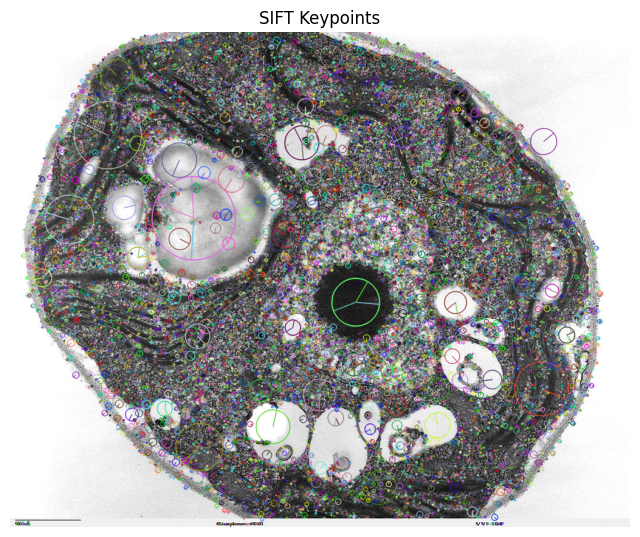

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(image_keypoints, cmap='gray')
plt.title("SIFT Keypoints")
plt.axis('off')
plt.show()

In [ ]:
print("Number of keypoints detected:", len(keypoints))
print("Descriptor shape:", descriptors.shape)

Number of keypoints detected: 9498
Descriptor shape: (9498, 128)


## 2. Generating a Panorama Using SIFT

To stitch two images into a panorama using SIFT features, follow the steps below:

---

### Step 1: Detect SIFT Keypoints and Descriptors

Compute **SIFT features** for both input images. SIFT (Scale-Invariant Feature Transform) detects distinctive and invariant keypoints in images and computes a descriptor for each one.

These keypoints capture important structures and textures in an image and remain robust under changes in scale, rotation, and perspective.

---

### Step 2: Feature Matching

Use a **feature matcher** (such as a FLANN (Fast Library for Approximate Nearest Neighbors)-based matcher or Brute-Force matcher) to find correspondences between descriptors in the two images.

This is typically done by comparing the **Euclidean distance** between descriptors. A common method is **Lowe’s ratio test**, which retains only matches where the nearest neighbor is significantly closer than the second nearest.

---

### Step 3: Estimate Homography

With the matched feature points, use **RANSAC (Random Sample Consensus)** to robustly estimate a **homography matrix** \( H \), which defines the geometric transformation between the two images.

Mathematically, the homography is defined as:

$$
\begin{bmatrix}
x' \\
y' \\
1
\end{bmatrix}
\approx
H
\begin{bmatrix}
x \\
y \\
1
\end{bmatrix}
$$

Where:

- $ (x, y) $: Coordinates in the first image
- $ (x', y') $: Corresponding coordinates in the second image
- $ H $: 3x3 transformation matrix that aligns the two planes

---

### Step 4: Warp and Stitch

Use the computed homography matrix to **warp one image** into the perspective of the other. This involves transforming the pixel positions of one image to align with the other.

After warping, the images can be **stitched together** by overlaying them and blending their boundaries, resulting in a **panorama**.

Various blending techniques (e.g., feathering, multiband blending) can be used to smooth the transition between overlapping regions and reduce visible seams.

---

### Summary

| Step             | Description |
|------------------|-------------|
| SIFT Detection   | Find keypoints and descriptors in both images |
| Feature Matching | Match descriptors using Euclidean distance |
| Homography Estimation | Estimate transformation using RANSAC |
| Warping & Stitching | Warp and blend to generate panorama |


In [ ]:
import numpy as np
import cv2

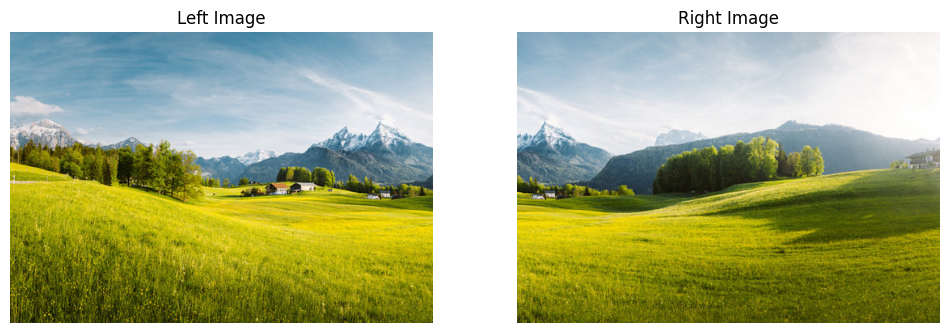

In [ ]:
# Load Images
img1 = cv2.imread('left.jpg')
img2 = cv2.imread('right.jpg')

# Convert BGR to RGB for displaying correctly with matplotlib
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# Display the images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img1_rgb)
plt.title('Left Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img2_rgb)
plt.title('Right Image')
plt.axis('off')

plt.show()

In [ ]:
# Convert to grayscale
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

In [ ]:
# SIFT detector
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

In [ ]:
# FLANN matcher parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

In [ ]:
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

In [ ]:
# Lowe’s ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)


print("Good matches found:", len(good_matches))


Good matches found: 154


Homography Matrix:
 [[ 1.00012822e+00 -2.32717557e-05 -4.23048553e+02]
 [-3.12271534e-04  1.00038012e+00  6.32156242e-02]
 [-6.20935292e-07  1.29245514e-06  1.00000000e+00]]


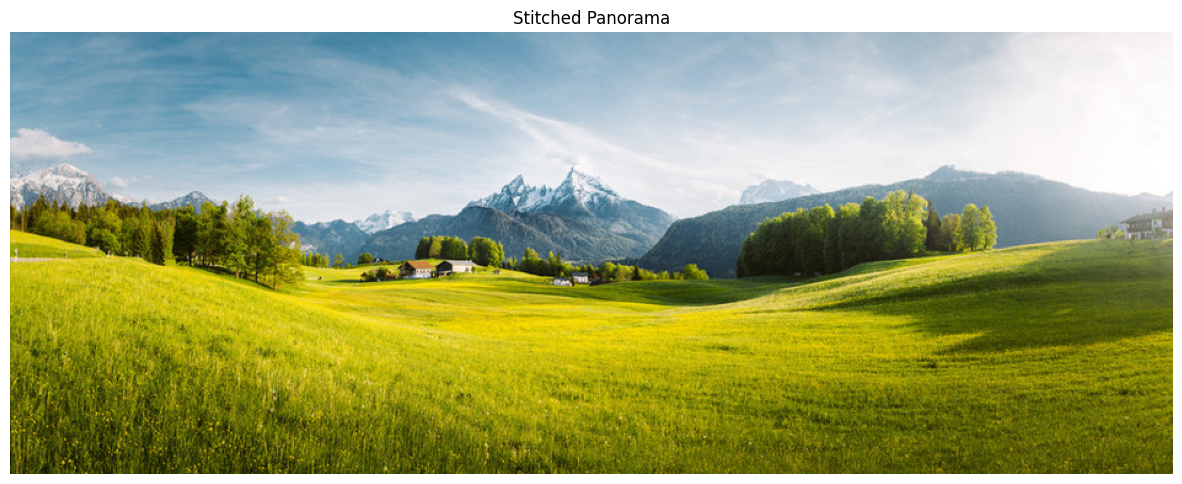

In [ ]:
# Extract location of good matches
if len(good_matches) > 4:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)

    # Compute Homography using RANSAC
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    print("Homography Matrix:\n", H)

    # Warp img1 to img2's plane
    h2, w2 = img2.shape[:2]
    h1, w1 = img1.shape[:2]
    # Corners of img1
    pts = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    pts_transformed = cv2.perspectiveTransform(pts, H)

    # Find dimensions of the stitched panorama
    pts_combined = np.concatenate((pts_transformed, np.float32([[0,0], [0,h2], [w2,h2], [w2,0]]).reshape(-1, 1, 2)), axis=0)
    [xmin, ymin] = np.int32(pts_combined.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts_combined.max(axis=0).ravel() + 0.5)

    # Translation matrix to shift the panorama
    translation = [-xmin, -ymin]
    H_translation = np.array([[1, 0, translation[0]],
                              [0, 1, translation[1]],
                              [0, 0, 1]])

    # Warp the left image
    panorama = cv2.warpPerspective(img1, H_translation.dot(H), (xmax - xmin, ymax - ymin))
    # Paste img2 into panorama
    panorama[translation[1]:h2+translation[1], translation[0]:w2+translation[0]] = img2

    # Convert panorama from BGR to RGB for display
    panorama_rgb = cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15, 8))
    plt.imshow(panorama_rgb)
    plt.title("Stitched Panorama")
    plt.axis('off')
    plt.show()
else:
    print("Not enough matches found to compute a panorama.")